In [45]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import optuna
from tqdm import tqdm
import matplotlib.pyplot as plt

class StandardScaler:
    def __init__(self):
        self.mean_ = None
        self.std_ = None
    
    def fit(self, X):
        self.mean_ = np.mean(X, axis=0)
        self.std_ = np.std(X, axis=0)
        self.std_[self.std_ == 0] = 1
        return self
    
    def transform(self, X):
        return (X - self.mean_) / self.std_
    
    def fit_transform(self, X):
        return self.fit(X).transform(X)
    
    def inverse_transform(self, X):
        return X * self.std_ + self.mean_

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, dropout=0.1):
        super(LSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size, 
            hidden_size, 
            num_layers, 
            dropout=dropout if num_layers > 1 else 0,
            batch_first=True
        )
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0))
    
        out = self.dropout(out[:, -1, :])
        out = self.fc(out)
        return out

In [46]:
def calculate_pocid(actual, predicted):
    """
    Calcula POCID (Prediction of Change in Direction)
    """
    if len(actual) < 2 or len(predicted) < 2:
        return 0.0
    
    actual_direction = np.diff(actual) > 0  
    
    predicted_direction = np.diff(predicted) > 0  
    
    correct_predictions = actual_direction == predicted_direction
    

    pocid = np.mean(correct_predictions) * 100
    
    return pocid

def window_data(X_features, y_target, window_size):
    """
    Cria janelas deslizantes dos dados
    """
    X, y = [], []
    for i in range(len(X_features) - window_size):
        X.append(X_features[i:i+window_size])

        y.append(y_target[i+window_size])
    return np.array(X), np.array(y)

def prepare_data(train_path, val_path, test_path, window_size, feature_cols):
    """
    Prepara os dados para treinamento
    
    Args:
        feature_cols: lista de colunas para usar como features
    """
    train_df = pd.read_csv(train_path)
    val_df = pd.read_csv(val_path)
    test_df = pd.read_csv(test_path)
    
    target_col = 'close'
    
    print(f"\n📊 Usando features: {feature_cols}")
    print(f"🎯 Target: {target_col}")
    
    scaler_X = StandardScaler()
    train_X = scaler_X.fit_transform(train_df[feature_cols].values)
    val_X = scaler_X.transform(val_df[feature_cols].values)
    test_X = scaler_X.transform(test_df[feature_cols].values)
    
    scaler_y = StandardScaler()
    train_y = scaler_y.fit_transform(train_df[[target_col]].values).flatten()
    val_y = scaler_y.transform(val_df[[target_col]].values).flatten()
    test_y = scaler_y.transform(test_df[[target_col]].values).flatten()
    

    X_train, y_train = window_data(train_X, train_y, window_size)
    X_val, y_val = window_data(val_X, val_y, window_size)
    X_test, y_test = window_data(test_X, test_y, window_size)
    
    print(f"Shapes após window_data:")
    print(f"  X_train: {X_train.shape}, y_train: {y_train.shape}")
    print(f"  X_val: {X_val.shape}, y_val: {y_val.shape}")
    print(f"  X_test: {X_test.shape}, y_test: {y_test.shape}")
    
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler_y

In [47]:
def train_model(X_train, y_train, X_val, y_val, params, verbose=True):
    """Treina o modelo LSTM com early stopping"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    X_train_tensor = torch.FloatTensor(X_train).to(device)
    y_train_tensor = torch.FloatTensor(y_train).to(device)
    X_val_tensor = torch.FloatTensor(X_val).to(device)
    y_val_tensor = torch.FloatTensor(y_val).to(device)
    
    if verbose:
        print(f"Tensor shapes:")
        print(f"  X_train_tensor: {X_train_tensor.shape}")
        print(f"  y_train_tensor: {y_train_tensor.shape}")
   
    model = LSTMModel(
        input_size=X_train.shape[2],  
        hidden_size=params['hidden_size'],
        num_layers=1,
        dropout=0.1
    ).to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'])
    criterion = nn.MSELoss()
 
    best_val_loss = float('inf')
    patience = 7
    patience_counter = 0
    best_model_state = None
    
    for epoch in range(100):  
        model.train()
        total_train_loss = 0
        num_batches = 0
       
        for i in range(0, len(X_train_tensor), params['batch_size']):
            batch_X = X_train_tensor[i:i+params['batch_size']]
            batch_y = y_train_tensor[i:i+params['batch_size']]
            
            optimizer.zero_grad()
            outputs = model(batch_X).squeeze()
            
            if outputs.dim() == 0:
                outputs = outputs.unsqueeze(0)
            
            loss = criterion(outputs, batch_y)
            
            if params['clip_margin'] > 0:
                torch.nn.utils.clip_grad_norm_(model.parameters(), params['clip_margin'])
            
            loss.backward()
            optimizer.step()
            
            total_train_loss += loss.item()
            num_batches += 1

        model.eval()
        with torch.no_grad():
            val_outputs = model(X_val_tensor).squeeze()
            if val_outputs.dim() == 0:
                val_outputs = val_outputs.unsqueeze(0)
            val_loss = criterion(val_outputs, y_val_tensor).item()
     
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state = model.state_dict().copy()
        else:
            patience_counter += 1
            
        if patience_counter >= patience:
            break
    
    if best_model_state is not None:
        model.load_state_dict(best_model_state)
    
    return model, best_val_loss

In [48]:
def objective_factory(feature_cols):
    """Factory para criar função objetivo específica para um conjunto de features"""
    def objective(trial):
        params = {
            'batch_size': trial.suggest_categorical('batch_size', [16, 32, 64, 128]),
            'window_size': trial.suggest_int('window_size', 5, 100),
            'hidden_size': trial.suggest_categorical('hidden_size', [32, 64, 128, 256]),
            'clip_margin': trial.suggest_float('clip_margin', 0.1, 2.0),
            'learning_rate': trial.suggest_float('learning_rate', 1e-5, 1e-2, log=True)
        }
        
        try:
            (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler_y = prepare_data(
                'data_to_train/bitcoin_train_data.csv',
                'data_to_train/bitcoin_val_data.csv', 
                'data_to_train/bitcoin_test_data.csv',
                params['window_size'],
                feature_cols
            )
            
            model, val_loss = train_model(X_train, y_train, X_val, y_val, params, verbose=False)
            
            return val_loss
        
        except Exception as e:
            print(f"Erro no trial: {e}")
            return float('inf')
    
    return objective

def evaluate_final_model(model, X_test, y_test, scaler_y):
    """Avaliar modelo final no conjunto de teste"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    X_test_tensor = torch.FloatTensor(X_test).to(device)
    
    model.eval()
    with torch.no_grad():
        test_predictions = model(X_test_tensor).squeeze().cpu().numpy()
    
    if test_predictions.ndim == 0:
        test_predictions = np.array([test_predictions])
    
    test_predictions = scaler_y.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    mse = np.mean((test_predictions - y_test_original) ** 2)
    rmse = np.sqrt(mse)
    mae = np.mean(np.abs(test_predictions - y_test_original))
    
    pocid = calculate_pocid(y_test_original, test_predictions)
    
    return {
        'predictions': test_predictions,
        'actual': y_test_original,
        'rmse': rmse,
        'mae': mae,
        'mse': mse,
        'pocid': pocid
    }

In [49]:
def run_experiment(experiment_name, feature_cols, n_trials):
    """
    Executa um experimento completo
    """
    print(f"\n{'='*60}")
    print(f"🧪 EXPERIMENTO: {experiment_name}")
    print(f"📊 Features: {feature_cols}")
    print(f"{'='*60}")
    
    print("🔍 Iniciando otimização com Optuna...")
    study = optuna.create_study(direction='minimize')
    study.optimize(objective_factory(feature_cols), n_trials=n_trials)
    
    print(f"\n📈 Resultados da Otimização ({experiment_name}):")
    print("Melhores parâmetros:")
    for key, value in study.best_params.items():
        print(f"  {key}: {value}")
    print(f"Melhor loss de validação: {study.best_value:.6f}")
    
    print(f"\n🎯 Treinando modelo final ({experiment_name})...")
    best_params = study.best_params
    
    (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler_y = prepare_data(
        'data_to_train/bitcoin_train_data.csv',
        'data_to_train/bitcoin_val_data.csv',
        'data_to_train/bitcoin_test_data.csv',
        best_params['window_size'],
        feature_cols
    )
    
    final_model, _ = train_model(X_train, y_train, X_val, y_val, best_params)
    
    print(f"\n📊 Avaliando no conjunto de teste ({experiment_name}):")
    results = evaluate_final_model(final_model, X_test, y_test, scaler_y)
    
    print(f"RMSE: ${results['rmse']:.2f}")
    print(f"MAE: ${results['mae']:.2f}")
    print(f"MSE: ${results['mse']:.2f}")
    print(f"POCID: {results['pocid']:.2f}%")
    
    if results['pocid'] > 50:
        print(f"✅ Modelo está prevendo direção melhor que random ({results['pocid']:.1f}% > 50%)")
    else:
        print(f"❌ Modelo não está prevendo direção melhor que random ({results['pocid']:.1f}% ≤ 50%)")
    
    model_filename = f'lstm_{experiment_name.lower().replace(" ", "_")}_model.pth'
    torch.save({
        'model_state_dict': final_model.state_dict(),
        'best_params': best_params,
        'scaler_y': scaler_y,
        'input_size': X_train.shape[2],
        'feature_cols': feature_cols,
        'experiment_name': experiment_name
    }, model_filename)
    
    print(f"\n💾 Modelo salvo como '{model_filename}'")
    
    return {
        'experiment_name': experiment_name,
        'feature_cols': feature_cols,
        'study': study,
        'model': final_model,
        'results': results,
        'best_params': best_params,
        'filename': model_filename
    }

In [50]:
def compare_experiments(experiments):
    """
    Compara os resultados dos experimentos
    """
    print(f"\n{'='*80}")
    print("📊 COMPARAÇÃO DOS EXPERIMENTOS")
    print(f"{'='*80}")
    
    # Tabela de comparação
    print(f"{'Experimento':<25} {'Features':<8} {'RMSE':<10} {'MAE':<10} {'POCID':<8} {'Val Loss':<10}")
    print("-" * 80)
    
    best_experiment = None
    best_pocid = 0
    
    for exp in experiments:
        results = exp['results']
        val_loss = exp['study'].best_value
        n_features = len(exp['feature_cols'])
        
        print(f"{exp['experiment_name']:<25} {n_features:<8} "
              f"${results['rmse']:<9.2f} ${results['mae']:<9.2f} "
              f"{results['pocid']:<7.1f}% {val_loss:<10.6f}")
        
        if results['pocid'] > best_pocid:
            best_pocid = results['pocid']
            best_experiment = exp
    
    print("-" * 80)
    print(f"\n🏆 MELHOR EXPERIMENTO: {best_experiment['experiment_name']}")
    print(f"   Features: {best_experiment['feature_cols']}")
    print(f"   POCID: {best_experiment['results']['pocid']:.2f}%")
    print(f"   RMSE: ${best_experiment['results']['rmse']:.2f}")
    
    return best_experiment

In [51]:
def plot_comparison(experiments):
    """Plot comparativo dos experimentos"""
    plt.figure(figsize=(15, 10))
    
    for i, exp in enumerate(experiments):
        results = exp['results']
        
        plt.subplot(2, len(experiments), i+1)
        plot_len = min(100, len(results['actual']))
        plt.plot(results['actual'][-plot_len:], label='Real', alpha=0.7, linewidth=2)
        plt.plot(results['predictions'][-plot_len:], label='Predição', alpha=0.7, linewidth=2)
        plt.title(f"{exp['experiment_name']}\nPOCID: {results['pocid']:.1f}%")
        plt.xlabel('Tempo')
        plt.ylabel('Preço ($)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        plt.subplot(2, len(experiments), i+1+len(experiments))
        actual_dir = np.diff(results['actual'][-plot_len:]) > 0
        pred_dir = np.diff(results['predictions'][-plot_len:]) > 0
        correct_dir = actual_dir == pred_dir
        
        correct_indices = np.where(correct_dir)[0]
        wrong_indices = np.where(~correct_dir)[0]
        
        plt.scatter(correct_indices, [1]*len(correct_indices), 
                   color='green', alpha=0.6, label=f'Correto ({len(correct_indices)})', s=20)
        plt.scatter(wrong_indices, [0]*len(wrong_indices), 
                   color='red', alpha=0.6, label=f'Erro ({len(wrong_indices)})', s=20)
        
        plt.title(f'Predição de Direção')
        plt.xlabel('Tempo')
        plt.ylabel('Acerto/Erro')
        plt.yticks([0, 1], ['Erro', 'Acerto'])
        plt.legend()
        plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('comparison_close_vs_all_features.png', dpi=300, bbox_inches='tight')
    plt.show()

In [52]:
print("🚀 Iniciando Experimento 1: Apenas Close")

experiment_1 = run_experiment(
    experiment_name='Apenas Close',
    feature_cols=['close'],
    n_trials=50  
)

[I 2025-07-17 08:49:03,094] A new study created in memory with name: no-name-fdc8a9d4-adac-4255-aa5d-d0f88cab6e25


🚀 Iniciando Experimento 1: Apenas Close

🧪 EXPERIMENTO: Apenas Close
📊 Features: ['close']
🔍 Iniciando otimização com Optuna...

📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1283, 22, 1), y_train: (1283,)
  X_val: (413, 22, 1), y_val: (413,)
  X_test: (414, 22, 1), y_test: (414,)


[I 2025-07-17 08:49:04,132] Trial 0 finished with value: 0.0951303169131279 and parameters: {'batch_size': 64, 'window_size': 22, 'hidden_size': 32, 'clip_margin': 1.0503443235598309, 'learning_rate': 0.0030249807923289802}. Best is trial 0 with value: 0.0951303169131279.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1281, 24, 1), y_train: (1281,)
  X_val: (411, 24, 1), y_val: (411,)
  X_test: (412, 24, 1), y_test: (412,)


[I 2025-07-17 08:49:09,827] Trial 1 finished with value: 0.046732764691114426 and parameters: {'batch_size': 16, 'window_size': 24, 'hidden_size': 256, 'clip_margin': 1.8063136824334687, 'learning_rate': 0.0006542516593844062}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1240, 65, 1), y_train: (1240,)
  X_val: (370, 65, 1), y_val: (370,)
  X_test: (371, 65, 1), y_test: (371,)


[I 2025-07-17 08:49:13,637] Trial 2 finished with value: 0.07042240351438522 and parameters: {'batch_size': 32, 'window_size': 65, 'hidden_size': 256, 'clip_margin': 1.0483391932868353, 'learning_rate': 0.001550286358958615}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1258, 47, 1), y_train: (1258,)
  X_val: (388, 47, 1), y_val: (388,)
  X_test: (389, 47, 1), y_test: (389,)


[I 2025-07-17 08:49:15,070] Trial 3 finished with value: 0.31862306594848633 and parameters: {'batch_size': 64, 'window_size': 47, 'hidden_size': 32, 'clip_margin': 0.89043881819191, 'learning_rate': 0.000662443852618755}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1297, 8, 1), y_train: (1297,)
  X_val: (427, 8, 1), y_val: (427,)
  X_test: (428, 8, 1), y_test: (428,)


[I 2025-07-17 08:49:19,449] Trial 4 finished with value: 0.5063731074333191 and parameters: {'batch_size': 32, 'window_size': 8, 'hidden_size': 64, 'clip_margin': 0.8169907215248736, 'learning_rate': 6.488678292615255e-05}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1237, 68, 1), y_train: (1237,)
  X_val: (367, 68, 1), y_val: (367,)
  X_test: (368, 68, 1), y_test: (368,)


[I 2025-07-17 08:49:20,402] Trial 5 finished with value: 12.075603485107422 and parameters: {'batch_size': 128, 'window_size': 68, 'hidden_size': 32, 'clip_margin': 0.4293971312849585, 'learning_rate': 3.62988682859421e-05}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1224, 81, 1), y_train: (1224,)
  X_val: (354, 81, 1), y_val: (354,)
  X_test: (355, 81, 1), y_test: (355,)


[I 2025-07-17 08:49:21,051] Trial 6 finished with value: 1.4671344757080078 and parameters: {'batch_size': 32, 'window_size': 81, 'hidden_size': 128, 'clip_margin': 1.1003727434651884, 'learning_rate': 0.006544291357870993}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1287, 18, 1), y_train: (1287,)
  X_val: (417, 18, 1), y_val: (417,)
  X_test: (418, 18, 1), y_test: (418,)


[I 2025-07-17 08:49:22,660] Trial 7 finished with value: 0.17282319068908691 and parameters: {'batch_size': 32, 'window_size': 18, 'hidden_size': 128, 'clip_margin': 1.1278904422737108, 'learning_rate': 0.0016574275253172662}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1270, 35, 1), y_train: (1270,)
  X_val: (400, 35, 1), y_val: (400,)
  X_test: (401, 35, 1), y_test: (401,)


[I 2025-07-17 08:49:23,950] Trial 8 finished with value: 0.25742024183273315 and parameters: {'batch_size': 32, 'window_size': 35, 'hidden_size': 64, 'clip_margin': 1.608174140832849, 'learning_rate': 0.0010957103629605559}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1262, 43, 1), y_train: (1262,)
  X_val: (392, 43, 1), y_val: (392,)
  X_test: (393, 43, 1), y_test: (393,)


[I 2025-07-17 08:49:29,934] Trial 9 finished with value: 0.7698707580566406 and parameters: {'batch_size': 16, 'window_size': 43, 'hidden_size': 32, 'clip_margin': 0.9250982673062002, 'learning_rate': 0.00010280573587716021}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1207, 98, 1), y_train: (1207,)
  X_val: (337, 98, 1), y_val: (337,)
  X_test: (338, 98, 1), y_test: (338,)


[I 2025-07-17 08:49:44,025] Trial 10 finished with value: 0.06710924208164215 and parameters: {'batch_size': 16, 'window_size': 98, 'hidden_size': 256, 'clip_margin': 1.8965185083808347, 'learning_rate': 0.00021353379971614445}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1206, 99, 1), y_train: (1206,)
  X_val: (336, 99, 1), y_val: (336,)
  X_test: (337, 99, 1), y_test: (337,)


[I 2025-07-17 08:49:56,585] Trial 11 finished with value: 0.07230706512928009 and parameters: {'batch_size': 16, 'window_size': 99, 'hidden_size': 256, 'clip_margin': 1.9969682949258427, 'learning_rate': 0.0002388542185157866}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1213, 92, 1), y_train: (1213,)
  X_val: (343, 92, 1), y_val: (343,)
  X_test: (344, 92, 1), y_test: (344,)


[I 2025-07-17 08:50:09,668] Trial 12 finished with value: 0.4896766245365143 and parameters: {'batch_size': 16, 'window_size': 92, 'hidden_size': 256, 'clip_margin': 1.9697108770710885, 'learning_rate': 1.609103794818405e-05}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1243, 62, 1), y_train: (1243,)
  X_val: (373, 62, 1), y_val: (373,)
  X_test: (374, 62, 1), y_test: (374,)


[I 2025-07-17 08:50:17,489] Trial 13 finished with value: 0.08872321248054504 and parameters: {'batch_size': 16, 'window_size': 62, 'hidden_size': 256, 'clip_margin': 1.5722791800905611, 'learning_rate': 0.00034330904275008833}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1226, 79, 1), y_train: (1226,)
  X_val: (356, 79, 1), y_val: (356,)
  X_test: (357, 79, 1), y_test: (357,)


[I 2025-07-17 08:50:19,032] Trial 14 finished with value: 1.010455846786499 and parameters: {'batch_size': 16, 'window_size': 79, 'hidden_size': 256, 'clip_margin': 1.5904794649114762, 'learning_rate': 0.00020659907079570696}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1271, 34, 1), y_train: (1271,)
  X_val: (401, 34, 1), y_val: (401,)
  X_test: (402, 34, 1), y_test: (402,)


[I 2025-07-17 08:50:19,732] Trial 15 finished with value: 0.3013089895248413 and parameters: {'batch_size': 128, 'window_size': 34, 'hidden_size': 256, 'clip_margin': 1.7753864385607028, 'learning_rate': 0.00050786628945043}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1249, 56, 1), y_train: (1249,)
  X_val: (379, 56, 1), y_val: (379,)
  X_test: (380, 56, 1), y_test: (380,)


[I 2025-07-17 08:50:24,655] Trial 16 finished with value: 0.1711645871400833 and parameters: {'batch_size': 16, 'window_size': 56, 'hidden_size': 256, 'clip_margin': 1.5174612583702247, 'learning_rate': 0.0001245218656259872}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1300, 5, 1), y_train: (1300,)
  X_val: (430, 5, 1), y_val: (430,)
  X_test: (431, 5, 1), y_test: (431,)


[I 2025-07-17 08:50:27,313] Trial 17 finished with value: 0.09133318811655045 and parameters: {'batch_size': 16, 'window_size': 5, 'hidden_size': 256, 'clip_margin': 1.35453127209058, 'learning_rate': 0.004695669149438943}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1279, 26, 1), y_train: (1279,)
  X_val: (409, 26, 1), y_val: (409,)
  X_test: (410, 26, 1), y_test: (410,)


[I 2025-07-17 08:50:35,633] Trial 18 finished with value: 0.8618109822273254 and parameters: {'batch_size': 16, 'window_size': 26, 'hidden_size': 64, 'clip_margin': 0.10962941078157118, 'learning_rate': 2.735049137117019e-05}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1231, 74, 1), y_train: (1231,)
  X_val: (361, 74, 1), y_val: (361,)
  X_test: (362, 74, 1), y_test: (362,)


[I 2025-07-17 08:50:36,325] Trial 19 finished with value: 0.3085453510284424 and parameters: {'batch_size': 128, 'window_size': 74, 'hidden_size': 128, 'clip_margin': 1.8117988028644074, 'learning_rate': 0.0006589276743642051}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1214, 91, 1), y_train: (1214,)
  X_val: (344, 91, 1), y_val: (344,)
  X_test: (345, 91, 1), y_test: (345,)


[I 2025-07-17 08:50:42,631] Trial 20 finished with value: 0.168177992105484 and parameters: {'batch_size': 64, 'window_size': 91, 'hidden_size': 256, 'clip_margin': 1.333155690414295, 'learning_rate': 0.00010392137401305453}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1250, 55, 1), y_train: (1250,)
  X_val: (380, 55, 1), y_val: (380,)
  X_test: (381, 55, 1), y_test: (381,)


[I 2025-07-17 08:50:44,725] Trial 21 finished with value: 0.09098540991544724 and parameters: {'batch_size': 32, 'window_size': 55, 'hidden_size': 256, 'clip_margin': 0.6125480004558693, 'learning_rate': 0.0020126049670437366}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1240, 65, 1), y_train: (1240,)
  X_val: (370, 65, 1), y_val: (370,)
  X_test: (371, 65, 1), y_test: (371,)


[I 2025-07-17 08:50:45,570] Trial 22 finished with value: 7.133603096008301 and parameters: {'batch_size': 32, 'window_size': 65, 'hidden_size': 256, 'clip_margin': 1.3029221495629237, 'learning_rate': 0.009972419591159602}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1205, 100, 1), y_train: (1205,)
  X_val: (335, 100, 1), y_val: (335,)
  X_test: (336, 100, 1), y_test: (336,)


[I 2025-07-17 08:50:48,082] Trial 23 finished with value: 0.9703020453453064 and parameters: {'batch_size': 16, 'window_size': 100, 'hidden_size': 256, 'clip_margin': 1.7822447865242455, 'learning_rate': 0.00116295387377057}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1265, 40, 1), y_train: (1265,)
  X_val: (395, 40, 1), y_val: (395,)
  X_test: (396, 40, 1), y_test: (396,)


[I 2025-07-17 08:50:54,200] Trial 24 finished with value: 0.07456833869218826 and parameters: {'batch_size': 16, 'window_size': 40, 'hidden_size': 256, 'clip_margin': 0.7024896626608321, 'learning_rate': 0.0003940484188129039}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1221, 84, 1), y_train: (1221,)
  X_val: (351, 84, 1), y_val: (351,)
  X_test: (352, 84, 1), y_test: (352,)


[I 2025-07-17 08:50:55,253] Trial 25 finished with value: 0.9317479133605957 and parameters: {'batch_size': 32, 'window_size': 84, 'hidden_size': 256, 'clip_margin': 1.24962136958112, 'learning_rate': 0.0009737808387602321}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1292, 13, 1), y_train: (1292,)
  X_val: (422, 13, 1), y_val: (422,)
  X_test: (423, 13, 1), y_test: (423,)


[I 2025-07-17 08:50:55,555] Trial 26 finished with value: 0.7352806925773621 and parameters: {'batch_size': 64, 'window_size': 13, 'hidden_size': 256, 'clip_margin': 1.8719536392085816, 'learning_rate': 0.002615016150390525}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1274, 31, 1), y_train: (1274,)
  X_val: (404, 31, 1), y_val: (404,)
  X_test: (405, 31, 1), y_test: (405,)


[I 2025-07-17 08:50:56,715] Trial 27 finished with value: 0.31622180342674255 and parameters: {'batch_size': 128, 'window_size': 31, 'hidden_size': 128, 'clip_margin': 1.685498450068295, 'learning_rate': 0.00017775244344993472}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1232, 73, 1), y_train: (1232,)
  X_val: (362, 73, 1), y_val: (362,)
  X_test: (363, 73, 1), y_test: (363,)


[I 2025-07-17 08:51:00,113] Trial 28 finished with value: 0.08104663342237473 and parameters: {'batch_size': 16, 'window_size': 73, 'hidden_size': 64, 'clip_margin': 1.4395746473170368, 'learning_rate': 0.0007888250756600264}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1280, 25, 1), y_train: (1280,)
  X_val: (410, 25, 1), y_val: (410,)
  X_test: (411, 25, 1), y_test: (411,)


[I 2025-07-17 08:51:00,749] Trial 29 finished with value: 0.1976892203092575 and parameters: {'batch_size': 64, 'window_size': 25, 'hidden_size': 32, 'clip_margin': 0.9958575527660822, 'learning_rate': 0.003612358803208671}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1254, 51, 1), y_train: (1254,)
  X_val: (384, 51, 1), y_val: (384,)
  X_test: (385, 51, 1), y_test: (385,)


[I 2025-07-17 08:51:01,402] Trial 30 finished with value: 0.6997939944267273 and parameters: {'batch_size': 32, 'window_size': 51, 'hidden_size': 256, 'clip_margin': 1.174422594976281, 'learning_rate': 0.0018136291264985117}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1208, 97, 1), y_train: (1208,)
  X_val: (338, 97, 1), y_val: (338,)
  X_test: (339, 97, 1), y_test: (339,)


[I 2025-07-17 08:51:12,109] Trial 31 finished with value: 0.07848817855119705 and parameters: {'batch_size': 16, 'window_size': 97, 'hidden_size': 256, 'clip_margin': 1.9722239678852354, 'learning_rate': 0.00023246618470572965}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1216, 89, 1), y_train: (1216,)
  X_val: (346, 89, 1), y_val: (346,)
  X_test: (347, 89, 1), y_test: (347,)


[I 2025-07-17 08:51:24,676] Trial 32 finished with value: 0.059598688036203384 and parameters: {'batch_size': 16, 'window_size': 89, 'hidden_size': 256, 'clip_margin': 1.9317468759148713, 'learning_rate': 0.0002762117123966127}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1216, 89, 1), y_train: (1216,)
  X_val: (346, 89, 1), y_val: (346,)
  X_test: (347, 89, 1), y_test: (347,)


[I 2025-07-17 08:51:34,504] Trial 33 finished with value: 0.0680922120809555 and parameters: {'batch_size': 16, 'window_size': 89, 'hidden_size': 256, 'clip_margin': 1.6928977825824976, 'learning_rate': 0.0004129695967722979}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1215, 90, 1), y_train: (1215,)
  X_val: (345, 90, 1), y_val: (345,)
  X_test: (346, 90, 1), y_test: (346,)


[I 2025-07-17 08:51:46,670] Trial 34 finished with value: 0.058397114276885986 and parameters: {'batch_size': 16, 'window_size': 90, 'hidden_size': 256, 'clip_margin': 1.6699984243776957, 'learning_rate': 0.0004345004034616279}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1219, 86, 1), y_train: (1219,)
  X_val: (349, 86, 1), y_val: (349,)
  X_test: (350, 86, 1), y_test: (350,)


[I 2025-07-17 08:51:48,935] Trial 35 finished with value: 0.6935582160949707 and parameters: {'batch_size': 16, 'window_size': 86, 'hidden_size': 256, 'clip_margin': 1.8886337929920365, 'learning_rate': 0.00013703432496349114}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1229, 76, 1), y_train: (1229,)
  X_val: (359, 76, 1), y_val: (359,)
  X_test: (360, 76, 1), y_test: (360,)


[I 2025-07-17 08:51:52,348] Trial 36 finished with value: 0.2209867238998413 and parameters: {'batch_size': 16, 'window_size': 76, 'hidden_size': 32, 'clip_margin': 1.6964281055721502, 'learning_rate': 0.00047163580533198424}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1210, 95, 1), y_train: (1210,)
  X_val: (340, 95, 1), y_val: (340,)
  X_test: (341, 95, 1), y_test: (341,)


[I 2025-07-17 08:51:56,954] Trial 37 finished with value: 0.31370705366134644 and parameters: {'batch_size': 16, 'window_size': 95, 'hidden_size': 64, 'clip_margin': 1.4316079183323906, 'learning_rate': 8.470910329460587e-05}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1220, 85, 1), y_train: (1220,)
  X_val: (350, 85, 1), y_val: (350,)
  X_test: (351, 85, 1), y_test: (351,)


[I 2025-07-17 08:52:01,240] Trial 38 finished with value: 0.4315066337585449 and parameters: {'batch_size': 16, 'window_size': 85, 'hidden_size': 128, 'clip_margin': 1.8769347633139168, 'learning_rate': 4.568350328849873e-05}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1212, 93, 1), y_train: (1212,)
  X_val: (342, 93, 1), y_val: (342,)
  X_test: (343, 93, 1), y_test: (343,)


[I 2025-07-17 08:52:15,553] Trial 39 finished with value: 0.06284914910793304 and parameters: {'batch_size': 16, 'window_size': 93, 'hidden_size': 256, 'clip_margin': 1.6951820079842146, 'learning_rate': 0.00025744505385498853}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1235, 70, 1), y_train: (1235,)
  X_val: (365, 70, 1), y_val: (365,)
  X_test: (366, 70, 1), y_test: (366,)


[I 2025-07-17 08:52:17,342] Trial 40 finished with value: 0.3066386580467224 and parameters: {'batch_size': 64, 'window_size': 70, 'hidden_size': 32, 'clip_margin': 1.4688170032151435, 'learning_rate': 0.0002887048805741758}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1211, 94, 1), y_train: (1211,)
  X_val: (341, 94, 1), y_val: (341,)
  X_test: (342, 94, 1), y_test: (342,)


[I 2025-07-17 08:52:29,702] Trial 41 finished with value: 0.0950363352894783 and parameters: {'batch_size': 16, 'window_size': 94, 'hidden_size': 256, 'clip_margin': 1.7603183926504375, 'learning_rate': 0.0001624731802701375}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1224, 81, 1), y_train: (1224,)
  X_val: (354, 81, 1), y_val: (354,)
  X_test: (355, 81, 1), y_test: (355,)


[I 2025-07-17 08:52:36,901] Trial 42 finished with value: 0.05282687023282051 and parameters: {'batch_size': 16, 'window_size': 81, 'hidden_size': 256, 'clip_margin': 1.653259528311278, 'learning_rate': 0.0007177593021424404}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1224, 81, 1), y_train: (1224,)
  X_val: (354, 81, 1), y_val: (354,)
  X_test: (355, 81, 1), y_test: (355,)


[I 2025-07-17 08:52:44,141] Trial 43 finished with value: 0.04926249012351036 and parameters: {'batch_size': 16, 'window_size': 81, 'hidden_size': 256, 'clip_margin': 1.6041854428644005, 'learning_rate': 0.0006527241579704964}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1225, 80, 1), y_train: (1225,)
  X_val: (355, 80, 1), y_val: (355,)
  X_test: (356, 80, 1), y_test: (356,)


[I 2025-07-17 08:52:45,887] Trial 44 finished with value: 0.42188355326652527 and parameters: {'batch_size': 16, 'window_size': 80, 'hidden_size': 256, 'clip_margin': 1.6137914591747968, 'learning_rate': 0.0007010799778726009}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1245, 60, 1), y_train: (1245,)
  X_val: (375, 60, 1), y_val: (375,)
  X_test: (376, 60, 1), y_test: (376,)


[I 2025-07-17 08:52:47,249] Trial 45 finished with value: 0.48754486441612244 and parameters: {'batch_size': 16, 'window_size': 60, 'hidden_size': 256, 'clip_margin': 1.5339848069831172, 'learning_rate': 0.0005494302480340781}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1218, 87, 1), y_train: (1218,)
  X_val: (348, 87, 1), y_val: (348,)
  X_test: (349, 87, 1), y_test: (349,)


[I 2025-07-17 08:52:50,878] Trial 46 finished with value: 0.11260823160409927 and parameters: {'batch_size': 16, 'window_size': 87, 'hidden_size': 256, 'clip_margin': 1.637104787924648, 'learning_rate': 0.00122109389945553}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1223, 82, 1), y_train: (1223,)
  X_val: (353, 82, 1), y_val: (353,)
  X_test: (354, 82, 1), y_test: (354,)


[I 2025-07-17 08:52:52,541] Trial 47 finished with value: 0.5600051283836365 and parameters: {'batch_size': 16, 'window_size': 82, 'hidden_size': 256, 'clip_margin': 1.996271914959317, 'learning_rate': 0.00034059544381586314}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1227, 78, 1), y_train: (1227,)
  X_val: (357, 78, 1), y_val: (357,)
  X_test: (358, 78, 1), y_test: (358,)


[I 2025-07-17 08:52:53,525] Trial 48 finished with value: 0.1670377552509308 and parameters: {'batch_size': 128, 'window_size': 78, 'hidden_size': 64, 'clip_margin': 1.8325796523743392, 'learning_rate': 0.000754429398793708}. Best is trial 1 with value: 0.046732764691114426.



📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1236, 69, 1), y_train: (1236,)
  X_val: (366, 69, 1), y_val: (366,)
  X_test: (367, 69, 1), y_test: (367,)


[I 2025-07-17 08:52:58,282] Trial 49 finished with value: 0.0417073592543602 and parameters: {'batch_size': 16, 'window_size': 69, 'hidden_size': 128, 'clip_margin': 1.7548108006123877, 'learning_rate': 0.0015382662812164869}. Best is trial 49 with value: 0.0417073592543602.



📈 Resultados da Otimização (Apenas Close):
Melhores parâmetros:
  batch_size: 16
  window_size: 69
  hidden_size: 128
  clip_margin: 1.7548108006123877
  learning_rate: 0.0015382662812164869
Melhor loss de validação: 0.041707

🎯 Treinando modelo final (Apenas Close)...

📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1236, 69, 1), y_train: (1236,)
  X_val: (366, 69, 1), y_val: (366,)
  X_test: (367, 69, 1), y_test: (367,)
Tensor shapes:
  X_train_tensor: torch.Size([1236, 69, 1])
  y_train_tensor: torch.Size([1236])

📊 Avaliando no conjunto de teste (Apenas Close):
RMSE: $1404.74
MAE: $1270.84
MSE: $1973303.97
POCID: 46.17%
❌ Modelo não está prevendo direção melhor que random (46.2% ≤ 50%)

💾 Modelo salvo como 'lstm_apenas_close_model.pth'


In [53]:
print("🚀 Iniciando Experimento 2: Todas Features")

experiment_2 = run_experiment(
    experiment_name='Todas Features',
    feature_cols=['open', 'high', 'low', 'close', 'number_of_trades'],
    n_trials=50 
)

[I 2025-07-17 08:53:01,881] A new study created in memory with name: no-name-78e86365-7e19-4946-9cd4-1472af65bd4e


🚀 Iniciando Experimento 2: Todas Features

🧪 EXPERIMENTO: Todas Features
📊 Features: ['open', 'high', 'low', 'close', 'number_of_trades']
🔍 Iniciando otimização com Optuna...

📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1240, 65, 5), y_train: (1240,)
  X_val: (370, 65, 5), y_val: (370,)
  X_test: (371, 65, 5), y_test: (371,)


[I 2025-07-17 08:53:03,802] Trial 0 finished with value: 0.10746724158525467 and parameters: {'batch_size': 32, 'window_size': 65, 'hidden_size': 256, 'clip_margin': 1.8921870140831334, 'learning_rate': 0.0024303772873718378}. Best is trial 0 with value: 0.10746724158525467.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1218, 87, 5), y_train: (1218,)
  X_val: (348, 87, 5), y_val: (348,)
  X_test: (349, 87, 5), y_test: (349,)


[I 2025-07-17 08:53:08,437] Trial 1 finished with value: 0.8046095967292786 and parameters: {'batch_size': 32, 'window_size': 87, 'hidden_size': 64, 'clip_margin': 0.6057086058612033, 'learning_rate': 2.576055610967287e-05}. Best is trial 0 with value: 0.10746724158525467.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1261, 44, 5), y_train: (1261,)
  X_val: (391, 44, 5), y_val: (391,)
  X_test: (392, 44, 5), y_test: (392,)


[I 2025-07-17 08:53:17,655] Trial 2 finished with value: 0.7588176131248474 and parameters: {'batch_size': 16, 'window_size': 44, 'hidden_size': 64, 'clip_margin': 1.5198180270477446, 'learning_rate': 2.2333633934367085e-05}. Best is trial 0 with value: 0.10746724158525467.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1241, 64, 5), y_train: (1241,)
  X_val: (371, 64, 5), y_val: (371,)
  X_test: (372, 64, 5), y_test: (372,)


[I 2025-07-17 08:53:20,194] Trial 3 finished with value: 0.17294220626354218 and parameters: {'batch_size': 32, 'window_size': 64, 'hidden_size': 128, 'clip_margin': 1.464145880146499, 'learning_rate': 0.0001684594226460944}. Best is trial 0 with value: 0.10746724158525467.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1271, 34, 5), y_train: (1271,)
  X_val: (401, 34, 5), y_val: (401,)
  X_test: (402, 34, 5), y_test: (402,)


[I 2025-07-17 08:53:21,524] Trial 4 finished with value: 0.19139309227466583 and parameters: {'batch_size': 32, 'window_size': 34, 'hidden_size': 64, 'clip_margin': 0.14080793648193504, 'learning_rate': 0.0006772136050771532}. Best is trial 0 with value: 0.10746724158525467.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1248, 57, 5), y_train: (1248,)
  X_val: (378, 57, 5), y_val: (378,)
  X_test: (379, 57, 5), y_test: (379,)


[I 2025-07-17 08:53:36,189] Trial 5 finished with value: 0.07760735601186752 and parameters: {'batch_size': 16, 'window_size': 57, 'hidden_size': 256, 'clip_margin': 0.699725400062028, 'learning_rate': 5.0633554722379645e-05}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1259, 46, 5), y_train: (1259,)
  X_val: (389, 46, 5), y_val: (389,)
  X_test: (390, 46, 5), y_test: (390,)


[I 2025-07-17 08:53:36,766] Trial 6 finished with value: 0.21448016166687012 and parameters: {'batch_size': 128, 'window_size': 46, 'hidden_size': 256, 'clip_margin': 1.595139034764467, 'learning_rate': 0.0005346524481131228}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1282, 23, 5), y_train: (1282,)
  X_val: (412, 23, 5), y_val: (412,)
  X_test: (413, 23, 5), y_test: (413,)


[I 2025-07-17 08:53:37,006] Trial 7 finished with value: 0.3950468599796295 and parameters: {'batch_size': 128, 'window_size': 23, 'hidden_size': 32, 'clip_margin': 1.4866862063670734, 'learning_rate': 0.0019988532478465194}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1274, 31, 5), y_train: (1274,)
  X_val: (404, 31, 5), y_val: (404,)
  X_test: (405, 31, 5), y_test: (405,)


[I 2025-07-17 08:53:40,377] Trial 8 finished with value: 0.15103967487812042 and parameters: {'batch_size': 16, 'window_size': 31, 'hidden_size': 64, 'clip_margin': 0.7675446510535413, 'learning_rate': 0.0003796498751300003}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1286, 19, 5), y_train: (1286,)
  X_val: (416, 19, 5), y_val: (416,)
  X_test: (417, 19, 5), y_test: (417,)


[I 2025-07-17 08:53:41,220] Trial 9 finished with value: 0.1112489253282547 and parameters: {'batch_size': 64, 'window_size': 19, 'hidden_size': 256, 'clip_margin': 1.725358586011852, 'learning_rate': 0.0008500389239120477}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1212, 93, 5), y_train: (1212,)
  X_val: (342, 93, 5), y_val: (342,)
  X_test: (343, 93, 5), y_test: (343,)


[I 2025-07-17 08:53:44,213] Trial 10 finished with value: 0.28104516863822937 and parameters: {'batch_size': 16, 'window_size': 93, 'hidden_size': 128, 'clip_margin': 1.0236265022104527, 'learning_rate': 7.882340555741603e-05}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1237, 68, 5), y_train: (1237,)
  X_val: (367, 68, 5), y_val: (367,)
  X_test: (368, 68, 5), y_test: (368,)


[I 2025-07-17 08:53:44,840] Trial 11 finished with value: 0.31885039806365967 and parameters: {'batch_size': 64, 'window_size': 68, 'hidden_size': 256, 'clip_margin': 1.955535234344361, 'learning_rate': 0.00877239546489735}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1239, 66, 5), y_train: (1239,)
  X_val: (369, 66, 5), y_val: (369,)
  X_test: (370, 66, 5), y_test: (370,)


[I 2025-07-17 08:53:46,245] Trial 12 finished with value: 0.10573852062225342 and parameters: {'batch_size': 32, 'window_size': 66, 'hidden_size': 256, 'clip_margin': 0.4548239651461046, 'learning_rate': 0.0048150642863083685}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1227, 78, 5), y_train: (1227,)
  X_val: (357, 78, 5), y_val: (357,)
  X_test: (358, 78, 5), y_test: (358,)


[I 2025-07-17 08:54:02,968] Trial 13 finished with value: 0.28676727414131165 and parameters: {'batch_size': 16, 'window_size': 78, 'hidden_size': 256, 'clip_margin': 0.31516377127338224, 'learning_rate': 1.0792886133455336e-05}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1249, 56, 5), y_train: (1249,)
  X_val: (379, 56, 5), y_val: (379,)
  X_test: (380, 56, 5), y_test: (380,)


[I 2025-07-17 08:54:06,805] Trial 14 finished with value: 0.4694230854511261 and parameters: {'batch_size': 32, 'window_size': 56, 'hidden_size': 32, 'clip_margin': 0.6239952724105364, 'learning_rate': 8.305968019612976e-05}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1227, 78, 5), y_train: (1227,)
  X_val: (357, 78, 5), y_val: (357,)
  X_test: (358, 78, 5), y_test: (358,)


[I 2025-07-17 08:54:10,641] Trial 15 finished with value: 0.09774702787399292 and parameters: {'batch_size': 16, 'window_size': 78, 'hidden_size': 256, 'clip_margin': 1.0753081605788406, 'learning_rate': 0.005664974325806884}. Best is trial 5 with value: 0.07760735601186752.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1225, 80, 5), y_train: (1225,)
  X_val: (355, 80, 5), y_val: (355,)
  X_test: (356, 80, 5), y_test: (356,)


[I 2025-07-17 08:54:22,613] Trial 16 finished with value: 0.07759013772010803 and parameters: {'batch_size': 16, 'window_size': 80, 'hidden_size': 256, 'clip_margin': 1.095657153921165, 'learning_rate': 0.00015354336426609262}. Best is trial 16 with value: 0.07759013772010803.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1208, 97, 5), y_train: (1208,)
  X_val: (338, 97, 5), y_val: (338,)
  X_test: (339, 97, 5), y_test: (339,)


[I 2025-07-17 08:54:32,062] Trial 17 finished with value: 0.10412462055683136 and parameters: {'batch_size': 16, 'window_size': 97, 'hidden_size': 256, 'clip_margin': 1.1067470053203508, 'learning_rate': 0.00015620830414069962}. Best is trial 16 with value: 0.07759013772010803.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1228, 77, 5), y_train: (1228,)
  X_val: (358, 77, 5), y_val: (358,)
  X_test: (359, 77, 5), y_test: (359,)


[I 2025-07-17 08:54:39,967] Trial 18 finished with value: 0.6067439317703247 and parameters: {'batch_size': 16, 'window_size': 77, 'hidden_size': 32, 'clip_margin': 0.8745525759449517, 'learning_rate': 4.89565389223073e-05}. Best is trial 16 with value: 0.07759013772010803.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1256, 49, 5), y_train: (1256,)
  X_val: (386, 49, 5), y_val: (386,)
  X_test: (387, 49, 5), y_test: (387,)


[I 2025-07-17 08:54:42,010] Trial 19 finished with value: 0.1660889834165573 and parameters: {'batch_size': 16, 'window_size': 49, 'hidden_size': 128, 'clip_margin': 1.2804042981835708, 'learning_rate': 0.00022243010088854047}. Best is trial 16 with value: 0.07759013772010803.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1300, 5, 5), y_train: (1300,)
  X_val: (430, 5, 5), y_val: (430,)
  X_test: (431, 5, 5), y_test: (431,)


[I 2025-07-17 08:54:45,125] Trial 20 finished with value: 0.23278282582759857 and parameters: {'batch_size': 64, 'window_size': 5, 'hidden_size': 256, 'clip_margin': 1.2731089899519665, 'learning_rate': 4.730013461445488e-05}. Best is trial 16 with value: 0.07759013772010803.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1224, 81, 5), y_train: (1224,)
  X_val: (354, 81, 5), y_val: (354,)
  X_test: (355, 81, 5), y_test: (355,)


[I 2025-07-17 08:54:48,546] Trial 21 finished with value: 0.07808542251586914 and parameters: {'batch_size': 16, 'window_size': 81, 'hidden_size': 256, 'clip_margin': 0.9756684442578389, 'learning_rate': 0.0013498052476137957}. Best is trial 16 with value: 0.07759013772010803.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1221, 84, 5), y_train: (1221,)
  X_val: (351, 84, 5), y_val: (351,)
  X_test: (352, 84, 5), y_test: (352,)


[I 2025-07-17 08:54:51,787] Trial 22 finished with value: 0.05529473349452019 and parameters: {'batch_size': 16, 'window_size': 84, 'hidden_size': 256, 'clip_margin': 0.8602424403148563, 'learning_rate': 0.0009366557678508234}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1215, 90, 5), y_train: (1215,)
  X_val: (345, 90, 5), y_val: (345,)
  X_test: (346, 90, 5), y_test: (346,)


[I 2025-07-17 08:54:56,014] Trial 23 finished with value: 0.0864182636141777 and parameters: {'batch_size': 16, 'window_size': 90, 'hidden_size': 256, 'clip_margin': 0.741283125039586, 'learning_rate': 0.00033654479771257263}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1248, 57, 5), y_train: (1248,)
  X_val: (378, 57, 5), y_val: (378,)
  X_test: (379, 57, 5), y_test: (379,)


[I 2025-07-17 08:54:57,949] Trial 24 finished with value: 0.23551054298877716 and parameters: {'batch_size': 128, 'window_size': 57, 'hidden_size': 256, 'clip_margin': 1.2049595106935826, 'learning_rate': 0.00010372227871420427}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1205, 100, 5), y_train: (1205,)
  X_val: (335, 100, 5), y_val: (335,)
  X_test: (336, 100, 5), y_test: (336,)


[I 2025-07-17 08:55:05,653] Trial 25 finished with value: 0.22250831127166748 and parameters: {'batch_size': 16, 'window_size': 100, 'hidden_size': 256, 'clip_margin': 0.8914488942513425, 'learning_rate': 3.560707790255521e-05}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1233, 72, 5), y_train: (1233,)
  X_val: (363, 72, 5), y_val: (363,)
  X_test: (364, 72, 5), y_test: (364,)


[I 2025-07-17 08:55:16,380] Trial 26 finished with value: 0.5416404008865356 and parameters: {'batch_size': 16, 'window_size': 72, 'hidden_size': 256, 'clip_margin': 0.4824030805074986, 'learning_rate': 1.074168587581016e-05}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1218, 87, 5), y_train: (1218,)
  X_val: (348, 87, 5), y_val: (348,)
  X_test: (349, 87, 5), y_test: (349,)


[I 2025-07-17 08:55:18,371] Trial 27 finished with value: 0.09221784770488739 and parameters: {'batch_size': 16, 'window_size': 87, 'hidden_size': 128, 'clip_margin': 0.7785777211153395, 'learning_rate': 0.0012009970378023304}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1221, 84, 5), y_train: (1221,)
  X_val: (351, 84, 5), y_val: (351,)
  X_test: (352, 84, 5), y_test: (352,)


[I 2025-07-17 08:55:20,866] Trial 28 finished with value: 0.3435598909854889 and parameters: {'batch_size': 16, 'window_size': 84, 'hidden_size': 32, 'clip_margin': 0.5697666861025973, 'learning_rate': 0.0002500514711165006}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1247, 58, 5), y_train: (1247,)
  X_val: (377, 58, 5), y_val: (377,)
  X_test: (378, 58, 5), y_test: (378,)


[I 2025-07-17 08:55:22,205] Trial 29 finished with value: 0.09722389280796051 and parameters: {'batch_size': 128, 'window_size': 58, 'hidden_size': 256, 'clip_margin': 0.25820120233879307, 'learning_rate': 0.002544862089935729}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1232, 73, 5), y_train: (1232,)
  X_val: (362, 73, 5), y_val: (362,)
  X_test: (363, 73, 5), y_test: (363,)


[I 2025-07-17 08:55:23,519] Trial 30 finished with value: 0.29907986521720886 and parameters: {'batch_size': 64, 'window_size': 73, 'hidden_size': 256, 'clip_margin': 1.1664028681401626, 'learning_rate': 0.00011929520054827589}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1223, 82, 5), y_train: (1223,)
  X_val: (353, 82, 5), y_val: (353,)
  X_test: (354, 82, 5), y_test: (354,)


[I 2025-07-17 08:55:27,350] Trial 31 finished with value: 0.0559760257601738 and parameters: {'batch_size': 16, 'window_size': 82, 'hidden_size': 256, 'clip_margin': 0.956385000242065, 'learning_rate': 0.001466502675720209}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1214, 91, 5), y_train: (1214,)
  X_val: (344, 91, 5), y_val: (344,)
  X_test: (345, 91, 5), y_test: (345,)


[I 2025-07-17 08:55:29,241] Trial 32 finished with value: 0.23139049112796783 and parameters: {'batch_size': 16, 'window_size': 91, 'hidden_size': 256, 'clip_margin': 0.9037059654478423, 'learning_rate': 0.0026927277473978257}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1243, 62, 5), y_train: (1243,)
  X_val: (373, 62, 5), y_val: (373,)
  X_test: (374, 62, 5), y_test: (374,)


[I 2025-07-17 08:55:33,682] Trial 33 finished with value: 0.08831479400396347 and parameters: {'batch_size': 16, 'window_size': 62, 'hidden_size': 256, 'clip_margin': 0.9799214205823247, 'learning_rate': 0.00042669883777866495}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1221, 84, 5), y_train: (1221,)
  X_val: (351, 84, 5), y_val: (351,)
  X_test: (352, 84, 5), y_test: (352,)


[I 2025-07-17 08:55:35,841] Trial 34 finished with value: 0.07827205210924149 and parameters: {'batch_size': 16, 'window_size': 84, 'hidden_size': 64, 'clip_margin': 0.7870022292477753, 'learning_rate': 0.0009009839766199165}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1266, 39, 5), y_train: (1266,)
  X_val: (396, 39, 5), y_val: (396,)
  X_test: (397, 39, 5), y_test: (397,)


[I 2025-07-17 08:55:38,153] Trial 35 finished with value: 0.07761894911527634 and parameters: {'batch_size': 16, 'window_size': 39, 'hidden_size': 256, 'clip_margin': 1.3682074035119831, 'learning_rate': 0.0017246279302315975}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1232, 73, 5), y_train: (1232,)
  X_val: (362, 73, 5), y_val: (362,)
  X_test: (363, 73, 5), y_test: (363,)


[I 2025-07-17 08:55:43,040] Trial 36 finished with value: 0.10894852876663208 and parameters: {'batch_size': 16, 'window_size': 73, 'hidden_size': 64, 'clip_margin': 0.6237749206441676, 'learning_rate': 0.0005966575552403411}. Best is trial 22 with value: 0.05529473349452019.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1210, 95, 5), y_train: (1210,)
  X_val: (340, 95, 5), y_val: (340,)
  X_test: (341, 95, 5), y_test: (341,)


[I 2025-07-17 08:55:44,548] Trial 37 finished with value: 0.05082157626748085 and parameters: {'batch_size': 32, 'window_size': 95, 'hidden_size': 256, 'clip_margin': 0.7003035753453469, 'learning_rate': 0.003669552368961776}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1210, 95, 5), y_train: (1210,)
  X_val: (340, 95, 5), y_val: (340,)
  X_test: (341, 95, 5), y_test: (341,)


[I 2025-07-17 08:55:45,091] Trial 38 finished with value: 0.10416852682828903 and parameters: {'batch_size': 32, 'window_size': 95, 'hidden_size': 128, 'clip_margin': 0.4529403444539568, 'learning_rate': 0.0031746144833857456}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1218, 87, 5), y_train: (1218,)
  X_val: (348, 87, 5), y_val: (348,)
  X_test: (349, 87, 5), y_test: (349,)


[I 2025-07-17 08:55:46,623] Trial 39 finished with value: 0.09909632802009583 and parameters: {'batch_size': 32, 'window_size': 87, 'hidden_size': 256, 'clip_margin': 0.85842895958716, 'learning_rate': 0.004303740507697902}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1205, 100, 5), y_train: (1205,)
  X_val: (335, 100, 5), y_val: (335,)
  X_test: (336, 100, 5), y_test: (336,)


[I 2025-07-17 08:55:47,259] Trial 40 finished with value: 0.10625667124986649 and parameters: {'batch_size': 32, 'window_size': 100, 'hidden_size': 64, 'clip_margin': 0.676847582557608, 'learning_rate': 0.009647633730919387}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1216, 89, 5), y_train: (1216,)
  X_val: (346, 89, 5), y_val: (346,)
  X_test: (347, 89, 5), y_test: (347,)


[I 2025-07-17 08:55:56,604] Trial 41 finished with value: 0.25965893268585205 and parameters: {'batch_size': 32, 'window_size': 89, 'hidden_size': 256, 'clip_margin': 0.9873707800140898, 'learning_rate': 2.5673507397180427e-05}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1223, 82, 5), y_train: (1223,)
  X_val: (353, 82, 5), y_val: (353,)
  X_test: (354, 82, 5), y_test: (354,)


[I 2025-07-17 08:55:57,632] Trial 42 finished with value: 0.09987033158540726 and parameters: {'batch_size': 128, 'window_size': 82, 'hidden_size': 256, 'clip_margin': 0.7266389156353004, 'learning_rate': 0.0015584024116381111}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1236, 69, 5), y_train: (1236,)
  X_val: (366, 69, 5), y_val: (366,)
  X_test: (367, 69, 5), y_test: (367,)


[I 2025-07-17 08:55:59,505] Trial 43 finished with value: 0.13420575857162476 and parameters: {'batch_size': 32, 'window_size': 69, 'hidden_size': 256, 'clip_margin': 1.1388961890928915, 'learning_rate': 0.0009060858708469729}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1210, 95, 5), y_train: (1210,)
  X_val: (340, 95, 5), y_val: (340,)
  X_test: (341, 95, 5), y_test: (341,)


[I 2025-07-17 08:56:01,828] Trial 44 finished with value: 0.13432060182094574 and parameters: {'batch_size': 16, 'window_size': 95, 'hidden_size': 256, 'clip_margin': 1.783584230993912, 'learning_rate': 0.003905030300151249}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1243, 62, 5), y_train: (1243,)
  X_val: (373, 62, 5), y_val: (373,)
  X_test: (374, 62, 5), y_test: (374,)


[I 2025-07-17 08:56:03,851] Trial 45 finished with value: 13.873130798339844 and parameters: {'batch_size': 64, 'window_size': 62, 'hidden_size': 32, 'clip_margin': 0.567258990672083, 'learning_rate': 1.700754975259437e-05}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1254, 51, 5), y_train: (1254,)
  X_val: (384, 51, 5), y_val: (384,)
  X_test: (385, 51, 5), y_test: (385,)


[I 2025-07-17 08:56:08,791] Trial 46 finished with value: 0.16960132122039795 and parameters: {'batch_size': 16, 'window_size': 51, 'hidden_size': 256, 'clip_margin': 1.056109520093438, 'learning_rate': 6.161664598446103e-05}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1228, 77, 5), y_train: (1228,)
  X_val: (358, 77, 5), y_val: (358,)
  X_test: (359, 77, 5), y_test: (359,)


[I 2025-07-17 08:56:10,128] Trial 47 finished with value: 0.17648176848888397 and parameters: {'batch_size': 32, 'window_size': 77, 'hidden_size': 256, 'clip_margin': 0.3774657035316997, 'learning_rate': 0.00579895080954639}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1283, 22, 5), y_train: (1283,)
  X_val: (413, 22, 5), y_val: (413,)
  X_test: (414, 22, 5), y_test: (414,)


[I 2025-07-17 08:56:14,747] Trial 48 finished with value: 0.05897580087184906 and parameters: {'batch_size': 16, 'window_size': 22, 'hidden_size': 256, 'clip_margin': 0.10558492966688393, 'learning_rate': 0.0004980788955817816}. Best is trial 37 with value: 0.05082157626748085.



📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1281, 24, 5), y_train: (1281,)
  X_val: (411, 24, 5), y_val: (411,)
  X_test: (412, 24, 5), y_test: (412,)


[I 2025-07-17 08:56:19,603] Trial 49 finished with value: 0.05486143380403519 and parameters: {'batch_size': 16, 'window_size': 24, 'hidden_size': 256, 'clip_margin': 1.3457958164806358, 'learning_rate': 0.00043822126900192667}. Best is trial 37 with value: 0.05082157626748085.



📈 Resultados da Otimização (Todas Features):
Melhores parâmetros:
  batch_size: 32
  window_size: 95
  hidden_size: 256
  clip_margin: 0.7003035753453469
  learning_rate: 0.003669552368961776
Melhor loss de validação: 0.050822

🎯 Treinando modelo final (Todas Features)...

📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1210, 95, 5), y_train: (1210,)
  X_val: (340, 95, 5), y_val: (340,)
  X_test: (341, 95, 5), y_test: (341,)
Tensor shapes:
  X_train_tensor: torch.Size([1210, 95, 5])
  y_train_tensor: torch.Size([1210])

📊 Avaliando no conjunto de teste (Todas Features):
RMSE: $7406.69
MAE: $6805.53
MSE: $54859006.97
POCID: 48.82%
❌ Modelo não está prevendo direção melhor que random (48.8% ≤ 50%)

💾 Modelo salvo como 'lstm_todas_features_model.pth'



📊 COMPARAÇÃO DOS EXPERIMENTOS
Experimento               Features RMSE       MAE        POCID    Val Loss  
--------------------------------------------------------------------------------
Apenas Close              1        $1404.74   $1270.84   46.2   % 0.041707  
Todas Features            5        $7406.69   $6805.53   48.8   % 0.050822  
--------------------------------------------------------------------------------

🏆 MELHOR EXPERIMENTO: Todas Features
   Features: ['open', 'high', 'low', 'close', 'number_of_trades']
   POCID: 48.82%
   RMSE: $7406.69


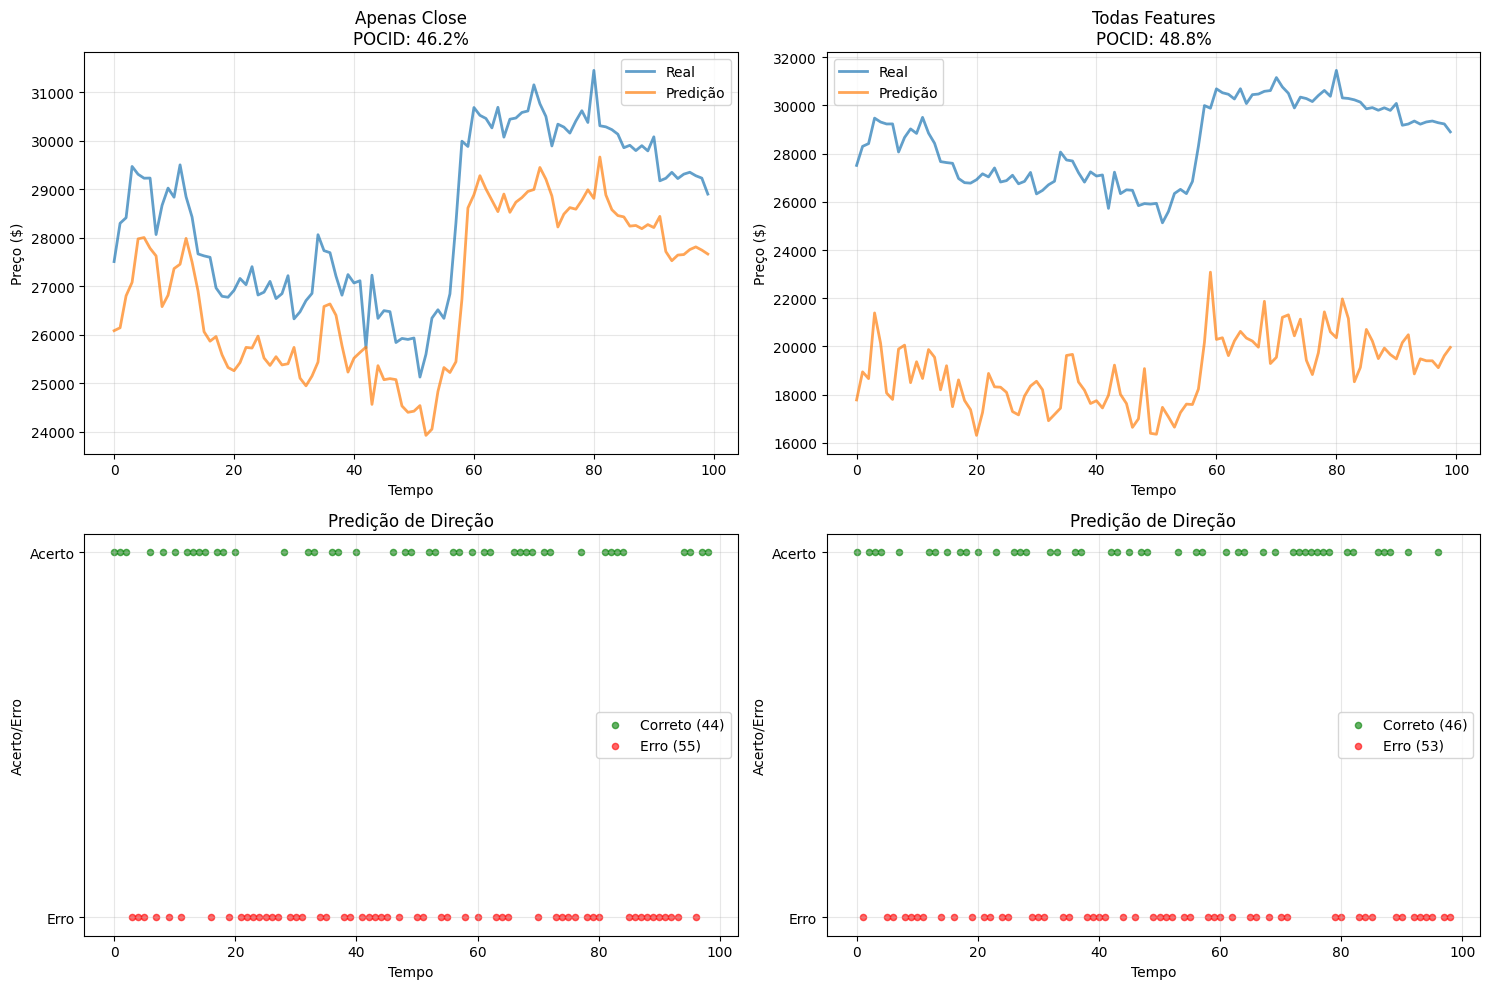


🎉 EXPERIMENTO CONCLUÍDO!
🏆 Vencedor: Todas Features
📊 Features vencedoras: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 POCID do vencedor: 48.82%


In [ ]:
experiments = [experiment_1, experiment_2]


best_experiment = compare_experiments(experiments)

plot_comparison(experiments)

print(f"\n🎉 EXPERIMENTO CONCLUÍDO!")
print(f"🏆 Vencedor: {best_experiment['experiment_name']}")
print(f"📊 Features vencedoras: {best_experiment['feature_cols']}")
print(f"🎯 POCID do vencedor: {best_experiment['results']['pocid']:.2f}%")

In [55]:
print("🔍 ANÁLISE DETALHADA DOS RESULTADOS:")
print()

for exp in experiments:
    print(f"📊 {exp['experiment_name']}:")
    print(f"   Melhores parâmetros: {exp['best_params']}")
    print(f"   POCID: {exp['results']['pocid']:.2f}%")
    print(f"   RMSE: ${exp['results']['rmse']:.2f}")
    print(f"   Arquivo salvo: {exp['filename']}")
    print()

if len(experiments) == 2:
    pocid_diff = experiments[1]['results']['pocid'] - experiments[0]['results']['pocid']
    print(f"🔄 Diferença de POCID: {pocid_diff:+.2f}%")
    
    if pocid_diff > 2:
        print("✅ Usar todas as features é claramente melhor!")
    elif pocid_diff < -2:
        print("✅ Usar apenas close é melhor!")
    else:
        print("🤔 Diferença pequena - ambos são similares")

🔍 ANÁLISE DETALHADA DOS RESULTADOS:

📊 Apenas Close:
   Melhores parâmetros: {'batch_size': 16, 'window_size': 69, 'hidden_size': 128, 'clip_margin': 1.7548108006123877, 'learning_rate': 0.0015382662812164869}
   POCID: 46.17%
   RMSE: $1404.74
   Arquivo salvo: lstm_apenas_close_model.pth

📊 Todas Features:
   Melhores parâmetros: {'batch_size': 32, 'window_size': 95, 'hidden_size': 256, 'clip_margin': 0.7003035753453469, 'learning_rate': 0.003669552368961776}
   POCID: 48.82%
   RMSE: $7406.69
   Arquivo salvo: lstm_todas_features_model.pth

🔄 Diferença de POCID: +2.65%
✅ Usar todas as features é claramente melhor!


🎨 Gerando visualizações completas da série temporal...
🎨 Gerando gráfico completo para: Apenas Close

📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1236, 69, 1), y_train: (1236,)
  X_val: (366, 69, 1), y_val: (366,)
  X_test: (367, 69, 1), y_test: (367,)


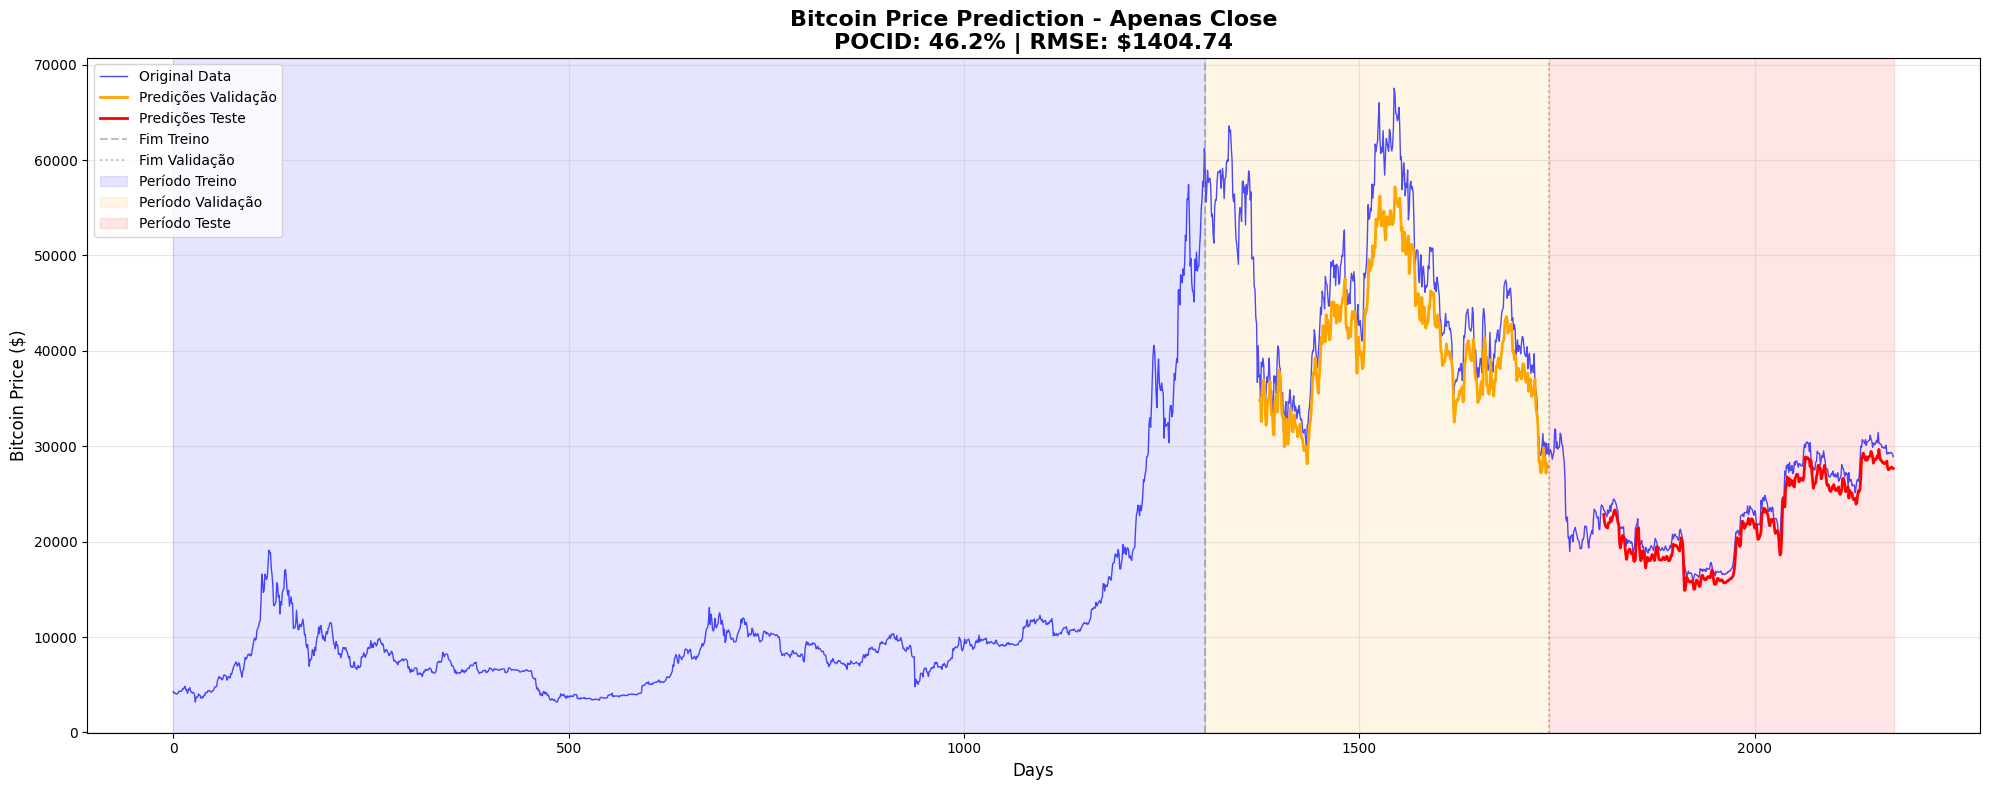

📊 Gráfico salvo como: full_series_apenas_close.png

📈 Estatísticas por período:
   Validação - POCID: 46.6%
   Teste - POCID: 46.2%
🎨 Gerando gráfico completo para: Todas Features

📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1210, 95, 5), y_train: (1210,)
  X_val: (340, 95, 5), y_val: (340,)
  X_test: (341, 95, 5), y_test: (341,)


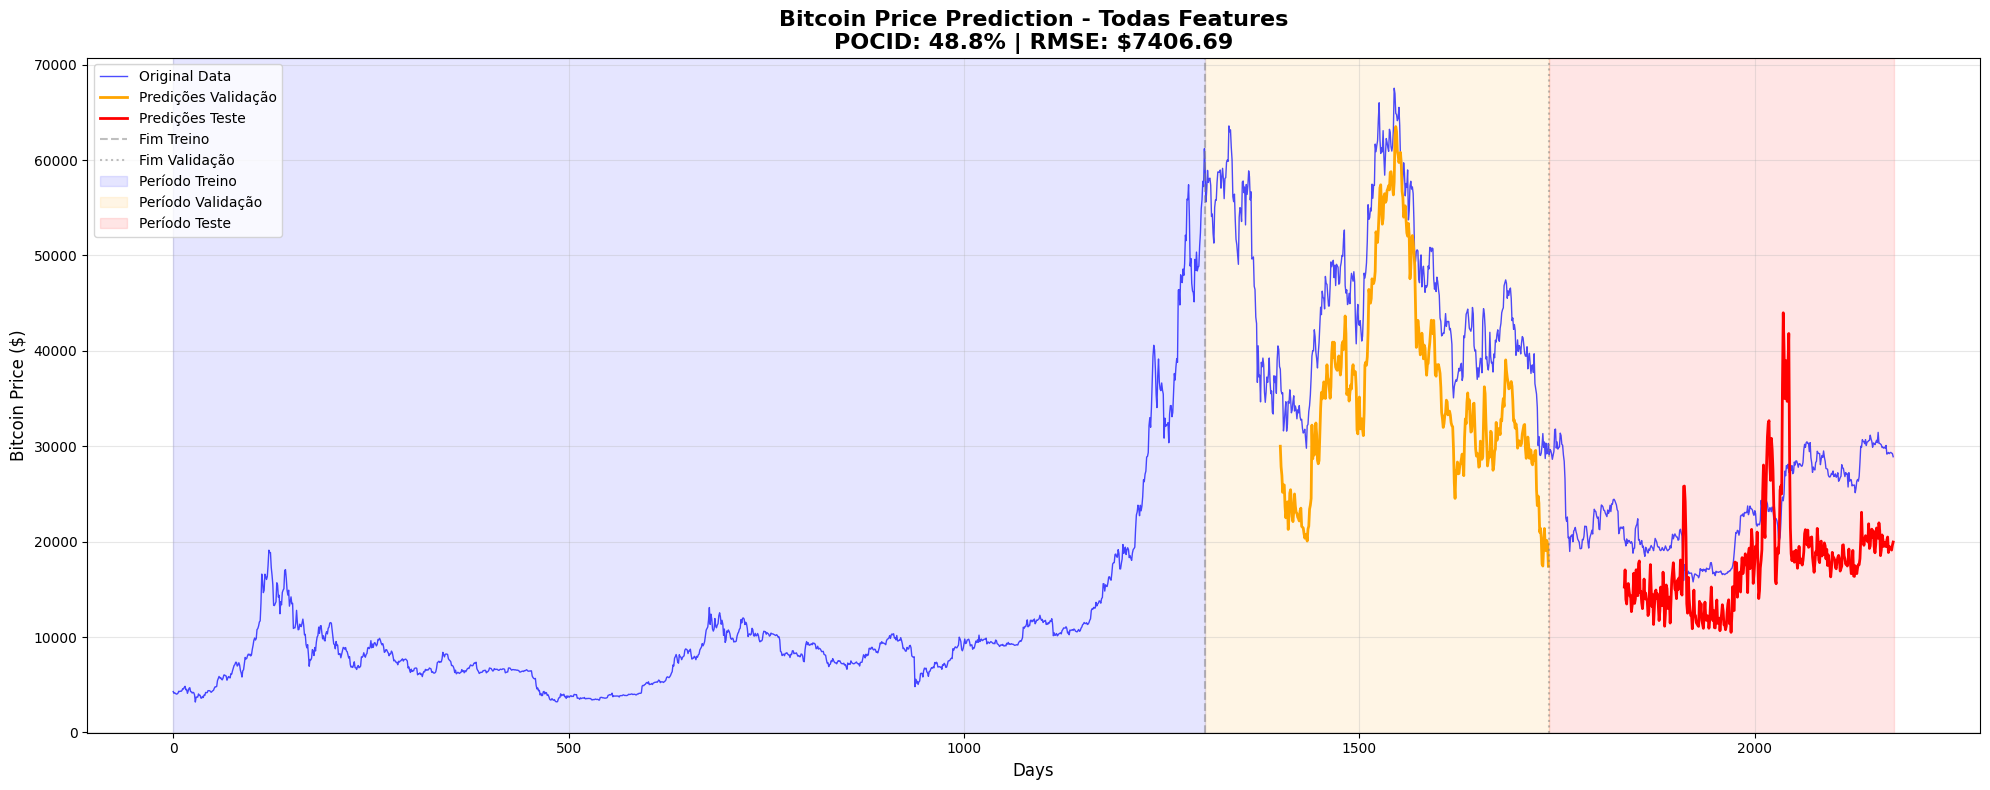

📊 Gráfico salvo como: full_series_todas_features.png

📈 Estatísticas por período:
   Validação - POCID: 42.5%
   Teste - POCID: 48.8%


In [ ]:
def plot_full_series_predictions(experiment, experiment_name):
    """
    Plota a série completa com predições coloridas por conjunto
    """
    print(f"🎨 Gerando gráfico completo para: {experiment_name}")
    
    train_df = pd.read_csv('data_to_train/bitcoin_train_data.csv')
    val_df = pd.read_csv('data_to_train/bitcoin_val_data.csv')
    test_df = pd.read_csv('data_to_train/bitcoin_test_data.csv')
    
    full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)
    
    best_params = experiment['best_params']
    feature_cols = experiment['feature_cols']
    window_size = best_params['window_size']
    (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler_y = prepare_data(
        'data_to_train/bitcoin_train_data.csv',
        'data_to_train/bitcoin_val_data.csv',
        'data_to_train/bitcoin_test_data.csv',
        window_size,
        feature_cols
    )
    
    model = experiment['model']
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    
    model.eval()
    with torch.no_grad():
        X_val_tensor = torch.FloatTensor(X_val).to(device)
        val_predictions = model(X_val_tensor).squeeze().cpu().numpy()
        
        X_test_tensor = torch.FloatTensor(X_test).to(device)
        test_predictions = model(X_test_tensor).squeeze().cpu().numpy()
    

    val_predictions = scaler_y.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
    test_predictions = scaler_y.inverse_transform(test_predictions.reshape(-1, 1)).flatten()
    
    y_val_original = scaler_y.inverse_transform(y_val.reshape(-1, 1)).flatten()
    y_test_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()
    
    total_len = len(full_df)
    train_len = len(train_df)
    val_len = len(val_df)
    test_len = len(test_df)
    
    val_start_idx = train_len + window_size
    test_start_idx = train_len + val_len + window_size
    x_full = range(total_len)
    y_full = full_df['close'].values
    
    val_pred_array = np.full(total_len, np.nan)
    test_pred_array = np.full(total_len, np.nan)
    
    val_pred_array[val_start_idx:val_start_idx + len(val_predictions)] = val_predictions
    test_pred_array[test_start_idx:test_start_idx + len(test_predictions)] = test_predictions
    
    plt.figure(figsize=(20, 8))
    
    plt.plot(x_full, y_full, label='Original Data', color='blue', alpha=0.7, linewidth=1)
    
    plt.plot(x_full, val_pred_array, label='Predições Validação', color='orange', linewidth=2)
    
    plt.plot(x_full, test_pred_array, label='Predições Teste', color='red', linewidth=2)
    
    plt.axvline(x=train_len, color='gray', linestyle='--', alpha=0.5, label='Fim Treino')
    plt.axvline(x=train_len + val_len, color='gray', linestyle=':', alpha=0.5, label='Fim Validação')
    
    plt.axvspan(0, train_len, alpha=0.1, color='blue', label='Período Treino')
    plt.axvspan(train_len, train_len + val_len, alpha=0.1, color='orange', label='Período Validação')
    plt.axvspan(train_len + val_len, total_len, alpha=0.1, color='red', label='Período Teste')
    
    plt.title(f'Bitcoin Price Prediction - {experiment_name}\n'
              f'POCID: {experiment["results"]["pocid"]:.1f}% | '
              f'RMSE: ${experiment["results"]["rmse"]:.2f}', 
              fontsize=16, fontweight='bold')
    plt.xlabel('Days', fontsize=12)
    plt.ylabel('Bitcoin Price ($)', fontsize=12)
    plt.legend(loc='upper left', fontsize=10)
    plt.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    filename = f'full_series_{experiment_name.lower().replace(" ", "_")}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    plt.show()
    
    print(f"📊 Gráfico salvo como: {filename}")
    
    val_pocid = calculate_pocid(y_val_original, val_predictions)
    test_pocid = calculate_pocid(y_test_original, test_predictions)
    
    print(f"\n📈 Estatísticas por período:")
    print(f"   Validação - POCID: {val_pocid:.1f}%")
    print(f"   Teste - POCID: {test_pocid:.1f}%")
    
    return {
        'val_pocid': val_pocid,
        'test_pocid': test_pocid,
        'filename': filename
    }

print("🎨 Gerando visualizações completas da série temporal...")

stats_exp1 = plot_full_series_predictions(experiment_1, "Apenas Close")

stats_exp2 = plot_full_series_predictions(experiment_2, "Todas Features")

🎨 Gerando comparação lado a lado...

📊 Usando features: ['close']
🎯 Target: close
Shapes após window_data:
  X_train: (1236, 69, 1), y_train: (1236,)
  X_val: (366, 69, 1), y_val: (366,)
  X_test: (367, 69, 1), y_test: (367,)

📊 Usando features: ['open', 'high', 'low', 'close', 'number_of_trades']
🎯 Target: close
Shapes após window_data:
  X_train: (1210, 95, 5), y_train: (1210,)
  X_val: (340, 95, 5), y_val: (340,)
  X_test: (341, 95, 5), y_test: (341,)


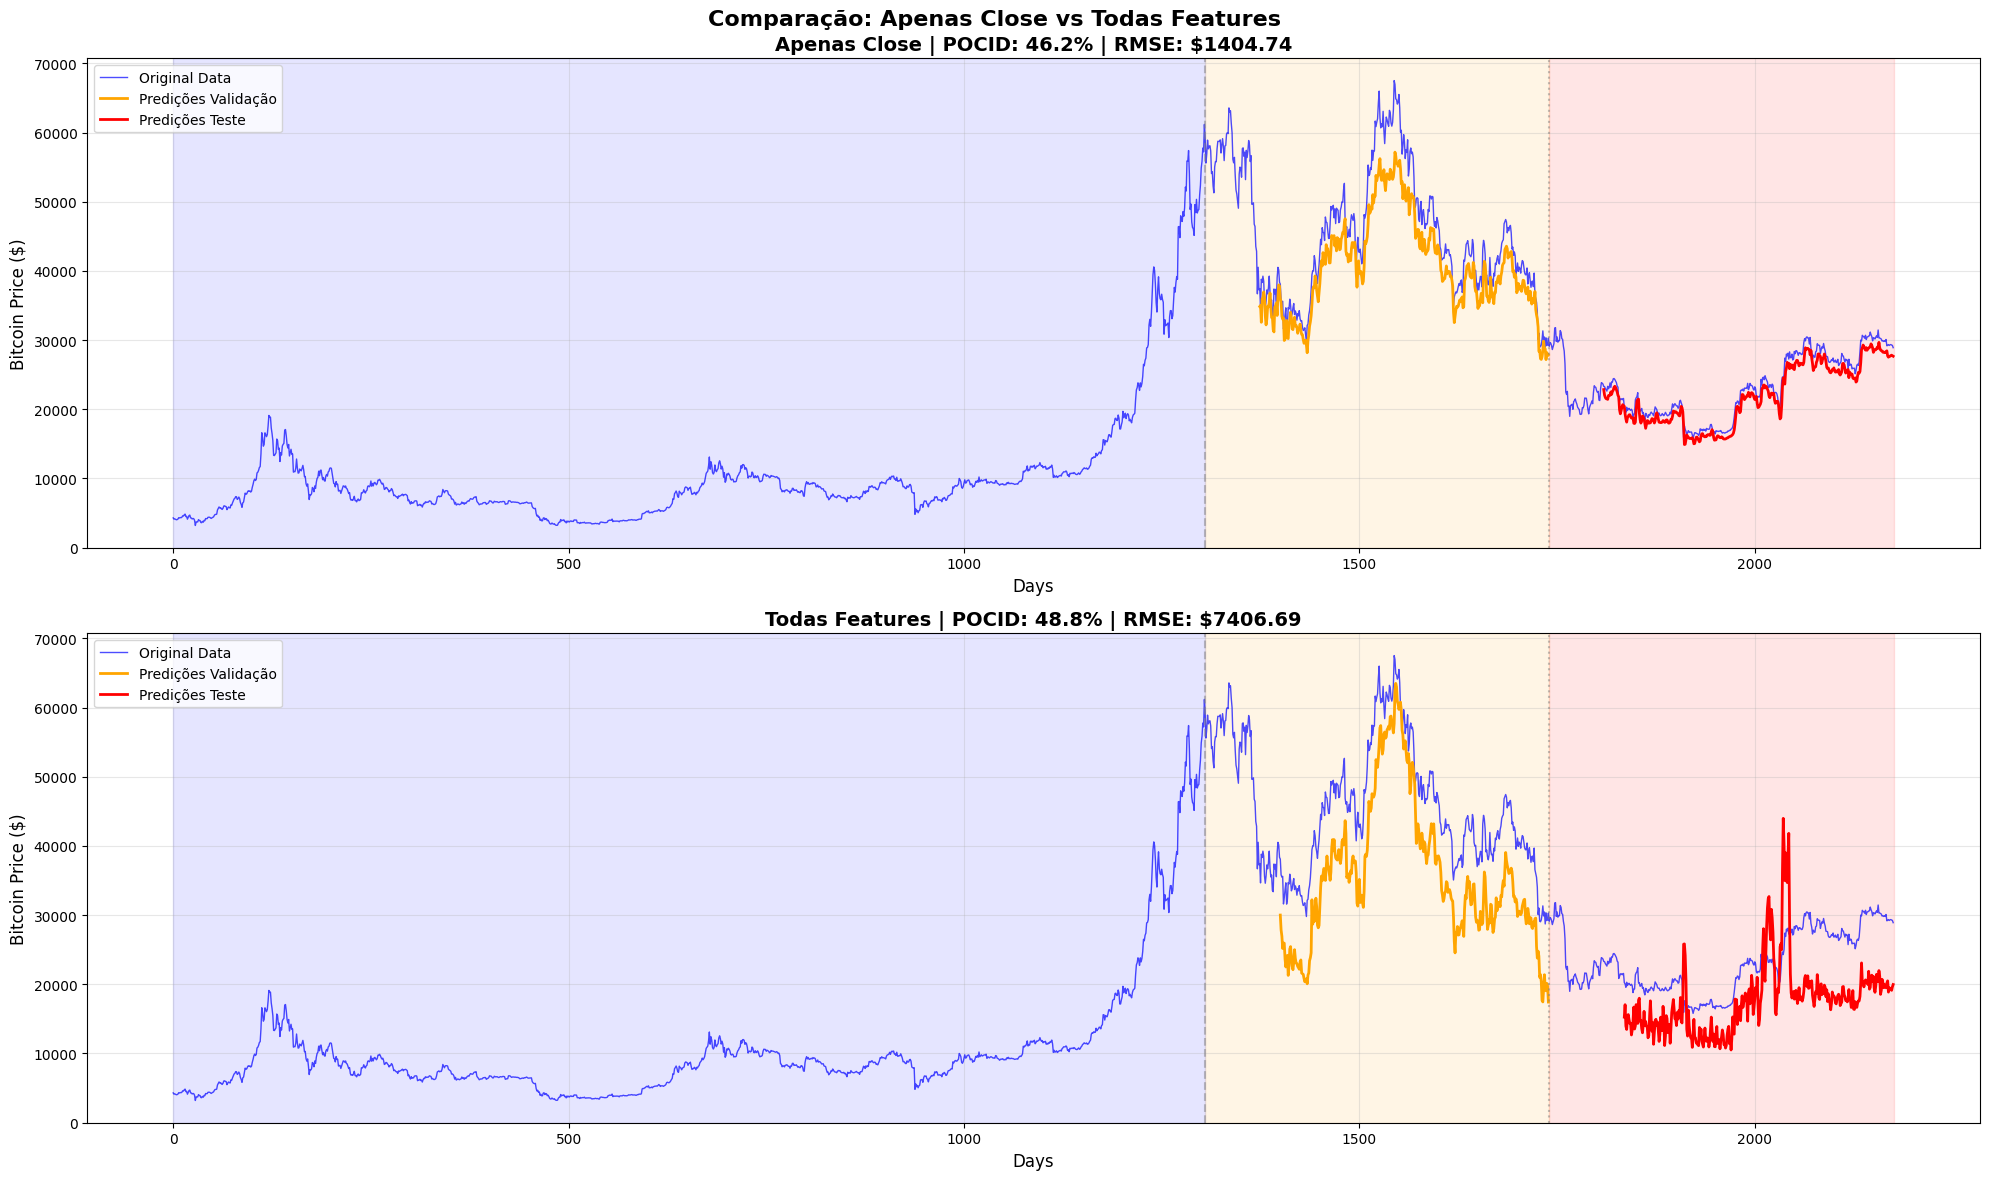

📊 Comparação salva como: comparison_full_series.png


In [58]:
def plot_side_by_side_comparison(exp1, exp2):
    """
    Plota comparação lado a lado dos dois experimentos
    """
    print("🎨 Gerando comparação lado a lado...")
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(20, 12))
    
    experiments = [exp1, exp2]
    axes = [ax1, ax2]
    
    for i, (exp, ax) in enumerate(zip(experiments, axes)):
        train_df = pd.read_csv('data_to_train/bitcoin_train_data.csv')
        val_df = pd.read_csv('data_to_train/bitcoin_val_data.csv')
        test_df = pd.read_csv('data_to_train/bitcoin_test_data.csv')
        full_df = pd.concat([train_df, val_df, test_df], ignore_index=True)

        best_params = exp['best_params']
        feature_cols = exp['feature_cols']
        window_size = best_params['window_size']
        
        (X_train, y_train), (X_val, y_val), (X_test, y_test), scaler_y = prepare_data(
            'data_to_train/bitcoin_train_data.csv',
            'data_to_train/bitcoin_val_data.csv',
            'data_to_train/bitcoin_test_data.csv',
            window_size,
            feature_cols
        )
        
        model = exp['model']
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
        model.eval()
        with torch.no_grad():
            X_val_tensor = torch.FloatTensor(X_val).to(device)
            val_predictions = model(X_val_tensor).squeeze().cpu().numpy()
            
            X_test_tensor = torch.FloatTensor(X_test).to(device)
            test_predictions = model(X_test_tensor).squeeze().cpu().numpy()
        
        val_predictions = scaler_y.inverse_transform(val_predictions.reshape(-1, 1)).flatten()
        test_predictions = scaler_y.inverse_transform(test_predictions.reshape(-1, 1)).flatten()

        total_len = len(full_df)
        train_len = len(train_df)
        val_len = len(val_df)
        
        val_start_idx = train_len + window_size
        test_start_idx = train_len + val_len + window_size
        
        x_full = range(total_len)
        y_full = full_df['close'].values
        
        val_pred_array = np.full(total_len, np.nan)
        test_pred_array = np.full(total_len, np.nan)
        
        val_pred_array[val_start_idx:val_start_idx + len(val_predictions)] = val_predictions
        test_pred_array[test_start_idx:test_start_idx + len(test_predictions)] = test_predictions
 
        ax.plot(x_full, y_full, label='Original Data', color='blue', alpha=0.7, linewidth=1)
        ax.plot(x_full, val_pred_array, label='Predições Validação', color='orange', linewidth=2)
        ax.plot(x_full, test_pred_array, label='Predições Teste', color='red', linewidth=2)
    
        ax.axvline(x=train_len, color='gray', linestyle='--', alpha=0.5)
        ax.axvline(x=train_len + val_len, color='gray', linestyle=':', alpha=0.5)
    
        ax.axvspan(0, train_len, alpha=0.1, color='blue')
        ax.axvspan(train_len, train_len + val_len, alpha=0.1, color='orange')
        ax.axvspan(train_len + val_len, total_len, alpha=0.1, color='red')
        
        ax.set_title(f'{exp["experiment_name"]} | POCID: {exp["results"]["pocid"]:.1f}% | RMSE: ${exp["results"]["rmse"]:.2f}', 
                    fontsize=14, fontweight='bold')
        ax.set_xlabel('Days', fontsize=12)
        ax.set_ylabel('Bitcoin Price ($)', fontsize=12)
        ax.legend(loc='upper left', fontsize=10)
        ax.grid(True, alpha=0.3)
    
    plt.suptitle('Comparação: Apenas Close vs Todas Features', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.savefig('comparison_full_series.png', dpi=300, bbox_inches='tight')
    plt.show()
    
    print("📊 Comparação salva como: comparison_full_series.png")

plot_side_by_side_comparison(experiment_1, experiment_2)